In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/progetto_comp_stat

Mounted at /gdrive
/gdrive/MyDrive/progetto_comp_stat


In [ ]:
!ls

sample_data


In [ ]:
#!/usr/bin/env python
# coding: utf-8

# #### Bayesian Physics-Informed Neural Network (with ODE)

# In[1]:


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

import load_data
import bnn
import bayesian
import hmc
import time
from sklearn.metrics import mean_squared_error


In [ ]:
# nmax = 2000 b
#%% Plotting loading
ColorS = [0.5, 0.00, 0.0]
ColorE = [0.8, 0.00, 0.0]
ColorI = [1.0, 0.65, 0.0]
ColorR = [0.0, 0.00, 0.7]

color_mu = 'tab:blue'
color_k = 'tab:red'
color_b = 'tab:green'


In [ ]:
def plotting(N, T_data, X_data, T_exact, X_exact, T_r, mu, std):
    plt.figure(figsize=(1100/72,400/72))

    plt.scatter(T_data[:N, :].numpy().flatten(), X_data[:N, :].numpy().flatten(),edgecolors=(0.0, 0.0, 0.7),marker='.',facecolors='none',s=500, lw=1.0,zorder=3, alpha=1.0, label=r'Training data')

    plt.scatter(T_exact[::2], X_exact[::2], s=100,linewidth=1.0, marker='x',color=ColorI, label='Data points')


    plt.fill_between(T_r.numpy().flatten(), (mu+2*std).flatten(), (mu-2*std).flatten(), zorder=1, alpha=0.10, color=ColorR)
    plt.plot(T_r.numpy().flatten(), mu.flatten(), color=(0.7, 0.0, 0.0),linewidth=3.0,linestyle="--", zorder=3, alpha=1.0,label=r'B-PINN')


    plt.yticks([0.3,0.9],fontsize=16)
    plt.xticks([0.0,0.2,0.6,0.8],fontsize=16)
    plt.legend(loc='upper right',ncol=1, fancybox=True, framealpha=0.,fontsize=24)
    plt.ylim([0.25,1])
    plt.xlabel("t",fontsize=24)
    plt.ylabel("x(t)",fontsize=24)
    plt.tight_layout()
    #plt.savefig(path2saveResults+'/PINN_data_BPINN_.pdf')
    plt.show()


T_data e X_data contengono i data temporali normalizzati (fino al 225 - training data) e i numeri in moving average di 7 giorni dei casi covid.

T_r contiene tutti gli istanti temporali normalizzati (con reshape).
T_exact  e X_exact contengono tutti i dati

In [ ]:
#%% load data


#
T_data, X_data, T_r, T_exact, X_exact, T_un, X_un, X_un_tf = load_data.load_covid_data()
print('Tensorflow version: ', tf.__version__)
print('Tensorflow-probability version: ', tfp.__version__)

# end

Tensorflow version:  2.15.0
Tensorflow-probability version:  0.23.0


Qui definisco l'equazione differenziale


In [ ]:

# In[2]:
# define PDE
def ode_fn(x, un, additional_variables):
    f = additional_variables
    with tf.GradientTape() as g_tt:
        g_tt.watch(x)
        with tf.GradientTape() as g_t:
            g_t.watch(x)
            u = un(x)
        u_x = g_t.gradient(u, x)
    u_xx = g_tt.gradient(u_x, x)
    r = 0.01*u_xx - f

    return r


In [ ]:
# define ODE
def ode_fn(t, fn, additional_variables):
    mu, k, b = additional_variables
    with tf.GradientTape() as g_tt:
        g_tt.watch(t)
        with tf.GradientTape() as g_t:
            g_t.watch(t)
            x = fn(t)
        x_t = g_t.gradient(x, t)
    x_tt = g_tt.gradient(x_t, t)
    f = 1/k*x_tt + mu/k*x_t + x - 0.54 #0.54 è il valore della x_0

    return f

In [ ]:
# #### Prior distributions and change of variables
#
# We define the prior distributions for $\mu, k, b$ to be independent LogNormal distributions:
# $$\log \mu \sim N(\log 2.2, 0.5) \\\log k \sim N(\log 350, 0.5), \\\log b \sim N(\log 0.56, 0.5)$$
#
# In practice, we instead sample $\log\mu - \log 2.2, \log k - \log 350$ and $\log b -\log 0.56$, so that those three
#quantities are independent and identically standard normal random variables. Suppose we have one posterior sample of
#those three quntities, $\epsilon_\mu, \epsilon_k, \epsilon_b$, then to obtain posterior sample of $\mu, k, b$, we do the following:
# $$\mu = e^{\log 2.2 + \epsilon_\mu} = 2.2 e^{\epsilon_\mu}, k = 350e^{\epsilon_k}, b = 0.56e^{\epsilon_b}.$$
#
# In this way, re-scaling is done and positivities are guaranteed.

# In[3]:
# N = 150 # 225, 200, 150, 100

# X_data = X_un_tf


def main(N):

    # create Bayesian neural network
    BNN = bnn.BNN(layers=[1, 32, 32, 1]) # qui stiamo creando un oggetto della classe BNN
    # specify number of observations

    # specify noise level for PDE
    noise_ode = (0.1, 0.1)
    # specify noise level for observations
    noise_u = 0.05
    # create Bayesian model
    model = bayesian.PI_Bayesian(
        x_u=T_data[:N, :],
        y_u=X_data[:N, :],
        # y_u=X_un_tf[:N, :],
        x_pde=T_r,
        pde_fn=ode_fn,
        L=3,
        noise_u=noise_u,
        noise_pde=noise_ode,
        prior_sigma=2,
    )
    # compute log posterior density function
    log_posterior = model.build_posterior(BNN.bnn_fn)
    # create HMC (Hamiltonian Monte Carlo) sampler
    hmc_kernel = hmc.AdaptiveHMC(
        target_log_prob_fn=log_posterior,
        init_state=BNN.variables+model.additional_inits,
        num_results=3000,
        num_burnin=4000,
        num_leapfrog_steps=50,
        step_size=0.0005,
    )
    # In[4]:


    # sampling
    start_time = time.perf_counter()
    samples, results = hmc_kernel.run_chain()
    Acc_rate = np.mean(results.inner_results.is_accepted.numpy())
    print('Accepted rate: ', Acc_rate)
    print(results.inner_results.accepted_results.step_size[0].numpy())
    stop_time = time.perf_counter()
    print('Duration time is %.3f seconds'%(stop_time - start_time))

    u_pred = BNN.bnn_infer_fn(T_r, samples[:6])

    mu = tf.reduce_mean(u_pred, axis=0).numpy()
    std = tf.math.reduce_std(u_pred, axis=0).numpy()

    return model, samples, u_pred, mu, std, Acc_rate

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Accepted rate:  0.36833333333333335
0.00077465834
Duration time is 204.587 seconds


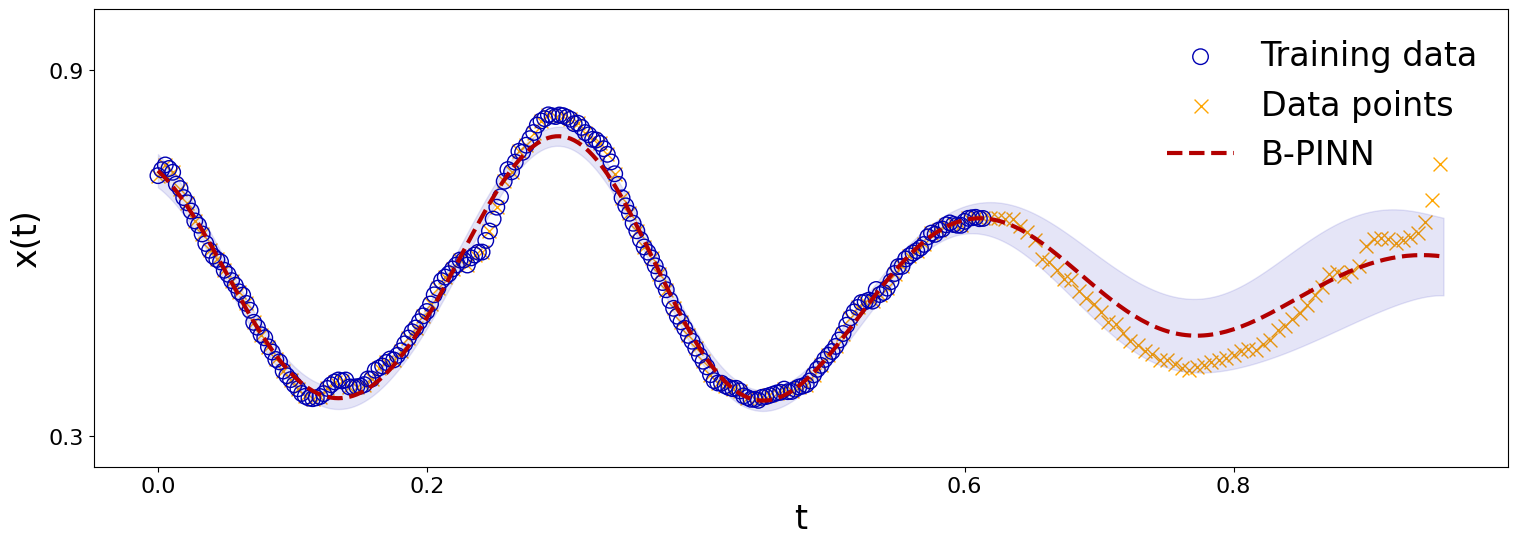

In [ ]:

# In[5]:


# compute posterior samples of x and store the results
# x_samples = BNN.bnn_infer_fn(T_r, samples[:2*model.L]).numpy()
# sio.savemat(
#     'results/out_{}.mat'.format(str(N)), {'x_samples': x_samples, 't': T_r.numpy()}
# )


# #### Posterior estimate on function



if __name__ == '__main__':
    N=225
    model, samples, u_pred, mu, std, Acc_rate = main(N)
    plotting(N, T_data, X_data, T_exact, X_exact, T_r, mu, std)



In [ ]:


# In[6]:




log_mu, log_k, log_b = samples[-3:]
mu, k, b = tf.exp(log_mu+model.log_mu_init), tf.exp(log_k+model.log_k_init), tf.exp(log_b+model.log_b_init)


In [ ]:
# In[ ]:
def PlotHist(ax, prior, post, var, color, limY, limX, limX0):

    ax.hist(post, bins=num_bins, density=True, label='posterior of '+var, color=color, alpha=0.7)
    mean = np.round(np.mean(post),3)
    std = np.round(np.std(post),2)
    ax.set_ylim([0,limY])
    ax.set_xlim([limX0,limX])
    plt.title(var+' = '+str(mean)+'$\pm$'+str(std),fontsize=24, color=color)
    legend = plt.legend(loc='upper right',fontsize=24,ncol=1, fancybox=True, framealpha=0.)
    plt.setp(legend.get_texts(), color=color)


(0.0, 1.8)

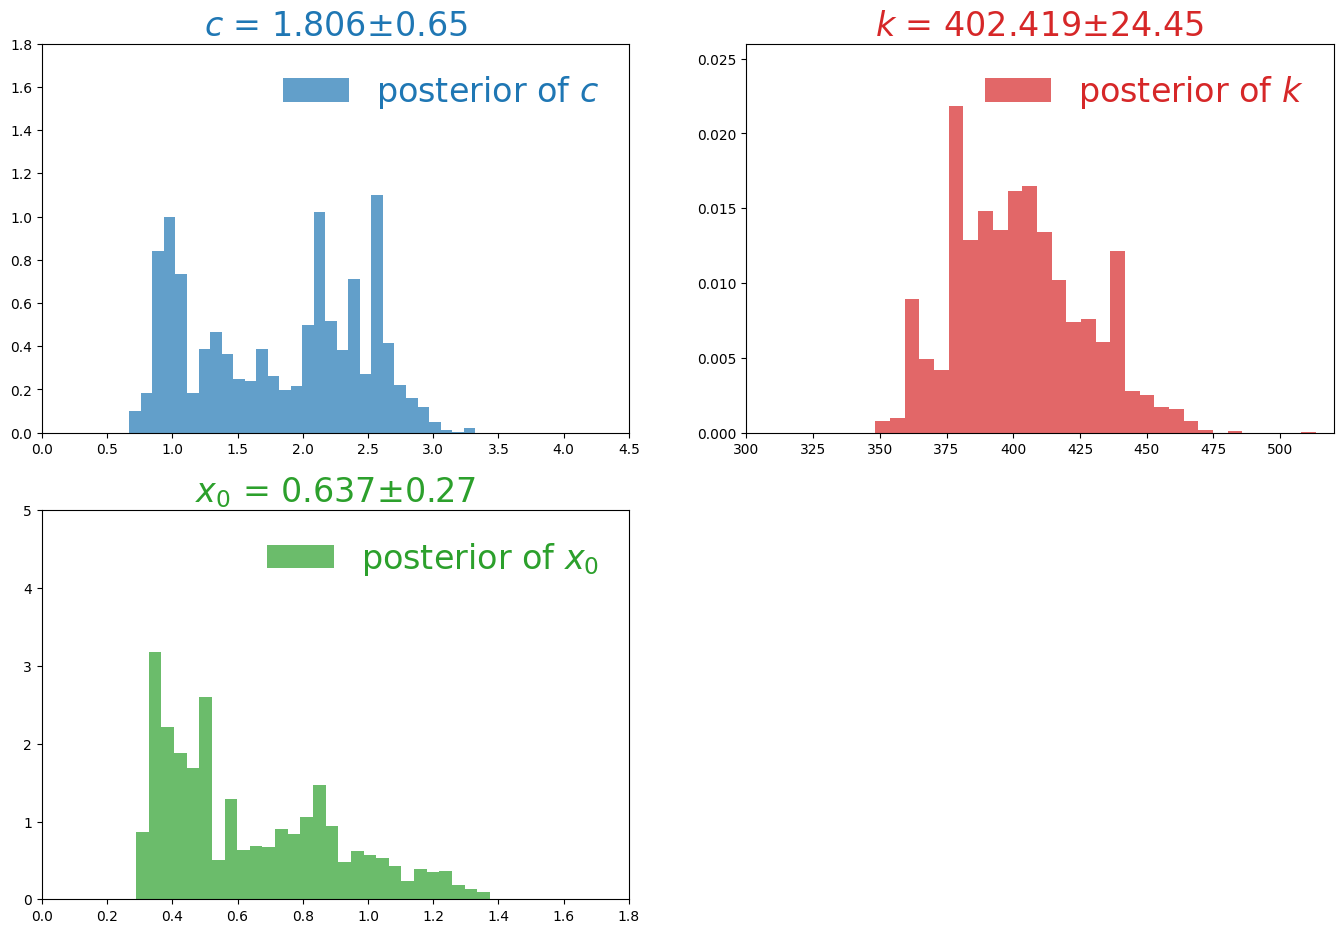

In [ ]:
num_bins = 30



fig = plt.figure(figsize=(1200/72,800/72))
gs = fig.add_gridspec(2, 2)



s = model.additional_priors[0].sample(3000)
prior = (tf.exp(s + model.log_mu_init)).numpy()
post = mu.numpy()
var = '$c$'
ax1 = plt.subplot(gs[0, 0])


PlotHist(ax1, prior, post, var, color_mu, 1.8, 4.5, 0.0)



s = model.additional_priors[1].sample(3000)
prior = (tf.exp(s + model.log_k_init)).numpy()
post = k.numpy()
var = '$k$'
ax2 = plt.subplot(gs[0, 1])


PlotHist(ax2, prior, post, var, color_k, 0.026, 550, 100)
ax2.set_xlim([300, 520])




s = model.additional_priors[2].sample(3000)
prior = (tf.exp(s + model.log_b_init)).numpy()
post = b.numpy()
var = '$x_0$'
ax3 = plt.subplot(gs[1, 0])



PlotHist(ax3, prior, post, var, color_b, 5, 4, 0.4)
ax3.set_xlim([0, 1.8])



#plt.savefig(path2saveResults+'/BPINN_Para_v2.pdf')

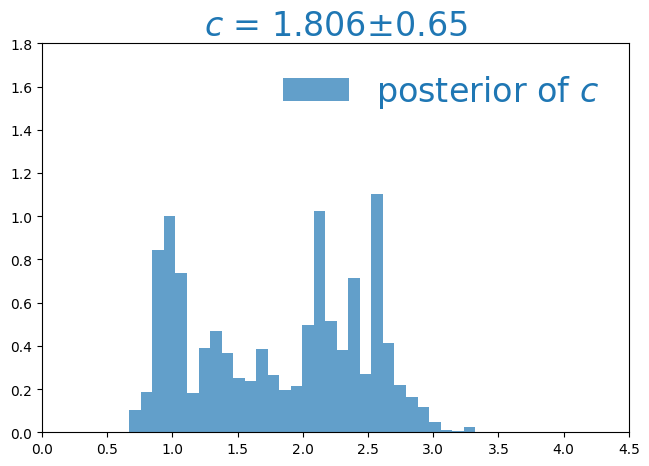

In [ ]:
fig = plt.figure(figsize=(1200/72,800/72))
s = model.additional_priors[0].sample(3000)
prior = (tf.exp(s + model.log_mu_init)).numpy()
post = mu.numpy()
var = '$c$'
ax1 = plt.subplot(gs[0, 0])


PlotHist(ax1, prior, post, var, color_mu, 1.8, 4.5, 0.0)

(300.0, 520.0)

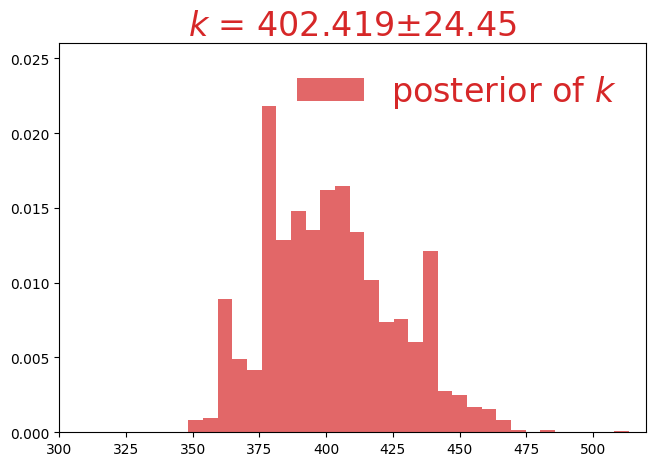

In [ ]:
fig = plt.figure(figsize=(1200/72,800/72))
s = model.additional_priors[1].sample(3000)
prior = (tf.exp(s + model.log_k_init)).numpy()
post = k.numpy()
var = '$k$'
ax2 = plt.subplot(gs[0, 1])


PlotHist(ax2, prior, post, var, color_k, 0.026, 550, 100)
ax2.set_xlim([300, 520])

(0.0, 1.8)

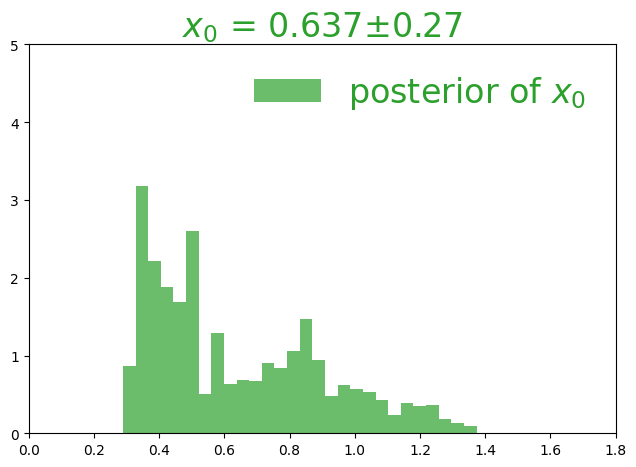

In [ ]:
fig = plt.figure(figsize=(1200/72,800/72))
s = model.additional_priors[2].sample(3000)
prior = (tf.exp(s + model.log_b_init)).numpy()
post = b.numpy()
var = '$x_0$'
ax3 = plt.subplot(gs[1, 0])



PlotHist(ax3, prior, post, var, color_b, 5, 4, 0.4)
ax3.set_xlim([0, 1.8])